In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import joblib
from collections import defaultdict as ddict
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [12, 6]

In [3]:
where_combined = [
    'none_mobile',
    'wifi_pc',
    'wifi_cloud',
    'cellular_cloud'
]

what_all = [
    'battery',
    'time_mean'
]

# possible services
U = [
    'cloud_commercial',
    'cloud_own',
    'pc',
    'mobile'
]

# possible mobile connections
C = [
    'wifi_public_no_passwd',
    'wifi_public_passwd',
    'cellular',
    'wifi_priv_known',
]

C_to_lvl = {v:i for i,v in enumerate(C)}

MAX_SEC_LEVEL = 4

models = ddict(dict)
models_dict = 'models/'

# reading pretrained models
for what in what_all:
    for where in where_combined:
        models[what][where] = joblib.load(f'{models_dict}{what}-{where}.joblib')

example_metrics = pd.read_csv('learning_data_new_dataset_no_outlier_no_zero_battery.csv', sep=';')[['metric', 'file_size']].drop_duplicates()

In [4]:
def security_filter(C, U, v, dj):
    Uj = None
    Cj = None
    
    if dj == 0:
        Uj = U
        Cj = C
        return Cj, Uj
    else:
        if dj > len(C) + v:
            Uj = U[dj:]
            Cj = []
        else:
            m = dj - v
            Uj = U[dj - 1:]
            Cj = C[m:]
    
    return Cj, Uj

def get_random_tasks(per_day, within_days):
    tasks = pd.concat([example_metrics.sample(per_day) for day in range(within_days)], ignore_index=True)
    for col in tasks.columns:
        tasks[col] = tasks[col].apply(lambda x: x + random.randint(-x//10, x//10))
        
    return tasks

def achieved_security_lvl(service, connection, vpn):
    if connection == None:
        return U.index(service)+1 # to be checked - not sure about the value 1
    else:
        return min(C_to_lvl[connection] + vpn, U.index(service))

def with_metadata(tasks):
    additional_metadata = [
        (
            tuple(sorted(random.sample(C, random.choice(range(len(C)))))), # available connections, sorted for order consistency
            random.choice([0, 1]),                                         # with vpn
            random.randint(0, 4)                                           # data confidentiality level
        ) for task in range(tasks.shape[0])
    ]
    tasks = pd.concat([tasks, pd.DataFrame(additional_metadata, columns=['available_connections', 'vpn', 'data_confid'])], axis=1)
    
    # tasks which may be used with given data confidentiality level
    tasks['filtered_connections'] = [sorted(list(set(meta[0]) & set(tuple(sorted(security_filter(C, U, meta[1], meta[2])[0])))), key=lambda x: C_to_lvl[x]) for meta in additional_metadata]
    tasks['allowed_services'] = [security_filter(C, U, meta[1], meta[2])[1] for meta in additional_metadata]
    
    return tasks

def predictions_for_task(task, with_security_filter=True):
    combinations = list(filter(
        lambda x: x[2] in where_combined, 
        [[
            cj, 
            uj, 
            cj.split('_')[0] + '_' + uj.split('_')[0],
            achieved_security_lvl(uj, cj, task.vpn)
        ] for cj, uj in itertools.product(task.filtered_connections if with_security_filter else task.available_connections, task.allowed_services)]
    ))
    combinations = list(filter(lambda x: not (x[0] != 'wifi_priv_known' and x[2] == 'wifi_pc'), combinations))
    combinations.append((None, 'mobile', 'none_mobile', achieved_security_lvl('mobile', None, task.vpn)))
    
    combinations = [[
        *row, 
        models['battery'][row[2]].predict([[task.metric, task.file_size]])[0], 
        models['time_mean'][row[2]].predict([[task.metric, task.file_size]])[0]
    ] for row in combinations]
        
    return combinations # (cj, uj, where_combined, achieved_sec, battery_usage, exec_time)
    
def predicts_wifi_priv_pc(possible_executions_no_sec):
    return sorted(list(filter(lambda x: x[2] == 'wifi_pc' or x[2] == 'none_mobile', possible_executions_no_sec)), key=lambda x: x[3])

def predict_public_cloud(possible_executions_no_sec):
    result = list(filter(lambda x: x[1] == 'cloud_commercial' or x[2] == 'none_mobile', possible_executions_no_sec))
    if len(result) == 1:
        return result[0]
    else:
        return random.choice(result[:-1])
    
def with_predictions(tasks, splits):
    random_sec = [] 
    best_battery = []
    best_time = []
    most_sec = []
    
    random_no_sec = []
    wifi_priv_pc_no_sec = []
    comm_cloud_no_sec = []
    
    for task in tasks.itertuples():
        possible_executions = predictions_for_task(task)
        possible_executions_no_sec = predictions_for_task(task, False)
        
        random_sec.append(random.choice(possible_executions))
        best_battery.append(sorted(possible_executions, key=lambda x: x[4])[0])
        best_time.append(sorted(possible_executions, key=lambda x: x[5])[0])
        most_sec.append(sorted(possible_executions, key=lambda x: -x[3])[0])

        random_no_sec.append(random.choice(possible_executions_no_sec))
        wifi_priv_pc_no_sec.append(predicts_wifi_priv_pc(possible_executions_no_sec)[0])
        comm_cloud_no_sec.append(predict_public_cloud(possible_executions_no_sec))
        
    def place_mean_and_std(place):
        lvl, battery, time = [np.array(np.split(resource, splits)).sum(axis=1) / (len(tasks) // splits) for resource in np.array(list(zip(*np.array(place)[:,3:].astype(float))))]
        
        return [(
                resource.mean(),
                resource.std()
            ) for resource in [lvl, battery, time]]
            
    return [
        ['Random Security', place_mean_and_std(random_sec)],
        ['Best Battery', place_mean_and_std(best_battery)],
        ['Best Time', place_mean_and_std(best_time)],
        ['Best Security', place_mean_and_std(most_sec)],
        ['Random No Sec', place_mean_and_std(random_no_sec)],
        ['Wifi Priv Pc No Sec', place_mean_and_std(wifi_priv_pc_no_sec)],
        ['Commercial Cloud No Sec', place_mean_and_std(comm_cloud_no_sec)]
    ]

In [13]:
tasks_per_day = 50
tasks_within_days = 100

tasks = get_random_tasks(per_day=tasks_per_day, within_days=tasks_within_days)
tasks = with_metadata(tasks)
tasks

,metric,file_size,available_connections,vpn,data_confid,filtered_connections,allowed_services
0,169641,1091727,"(wifi_public_no_passwd, wifi_public_passwd)",1,4,[],[mobile]
1,250937,1775784,"(cellular, wifi_public_no_passwd, wifi_public_...",0,2,[cellular],"[cloud_own, pc, mobile]"
2,27431,169565,"(wifi_priv_known, wifi_public_passwd)",0,3,[wifi_priv_known],"[pc, mobile]"
3,275939,1143813,"(wifi_priv_known, wifi_public_no_passwd, wifi_...",0,0,"[wifi_public_no_passwd, wifi_public_passwd, wi...","[cloud_commercial, cloud_own, pc, mobile]"
4,91938,633801,"(wifi_public_no_passwd,)",1,2,[],"[cloud_own, pc, mobile]"
...,...,...,...,...,...,...,...
4995,374773,1843245,"(wifi_priv_known, wifi_public_passwd)",0,0,"[wifi_public_passwd, wifi_priv_known]","[cloud_commercial, cloud_own, pc, mobile]"
4996,172919,895153,"(cellular, wifi_priv_known, wifi_public_no_pas...",0,4,[],[mobile]
4997,294349,1848828,"(cellular, wifi_priv_known)",1,0,"[cellular, wifi_priv_known]","[cloud_commercial, cloud_own, pc, mobile]"
4998,459455,2108687,(),1,0,[],"[cloud_commercial, cloud_own, pc, mobile]"


In [14]:
print('vpn available', a := len(tasks.vpn[tasks.vpn == 1]), a / 5000)
print('no connection available', b := len(tasks.available_connections[tasks.available_connections == ()]), b / 5000)
print('no connection available filtered', c := len(tasks.filtered_connections[tasks.filtered_connections.map(lambda x: True if len(x) == 0 else False)]), c / 5000)
print('tasks with most secure connection', d := len(tasks.available_connections[tasks.available_connections.map(lambda x: 'wifi_priv_known' in x)]), d / 5000)
print('no connection even whem connections are available', e := len(tasks[tasks.filtered_connections.map(lambda x: True if len(x) == 0 else False) & tasks.available_connections.map(lambda x: True if len(x) > 0 else False)]), e / 5000)

vpn available 2490 0.498
no connection available 1211 0.2422
no connection available filtered 2167 0.4334
tasks with most secure connection 1903 0.3806
no connection even whem connections are available 956 0.1912


In [33]:
tasks.available_connections.map(lambda x: True if len(x) > 0 else False)

0       False
1        True
2       False
3       False
4        True
        ...  
4995     True
4996     True
4997     True
4998    False
4999     True
Name: available_connections, Length: 5000, dtype: bool

In [39]:
tasks.filtered_connections.map(lambda x: True if len(x) == 0 else False)

0        True
1       False
2        True
3        True
4       False
        ...  
4995    False
4996    False
4997    False
4998     True
4999     True
Name: filtered_connections, Length: 5000, dtype: bool

In [40]:
len(tasks[tasks.filtered_connections.map(lambda x: True if len(x) == 0 else False) & tasks.available_connections.map(lambda x: True if len(x) > 0 else False)])

1015

In [6]:
strategies = with_predictions(tasks, tasks_within_days)

In [7]:
print(*strategies, sep='\n')

['Random Security', [(2.946, 0.2299130270341374), (0.17558939940893173, 0.020452204656286572), (34.315711260747435, 4.067189492730708)]]
['Best Battery', [(2.8634, 0.22506985582258682), (0.1373061471820679, 0.021991482810709107), (26.660155286368752, 3.2288780543787956)]]
['Best Time', [(3.2666000000000004, 0.1792663939504557), (0.14671289277612304, 0.021149348278198615), (23.246366680787563, 2.967881099383131)]]
['Best Security', [(4.0, 0.0), (0.2316509955103918, 0.02306947985708234), (32.445470380781444, 3.4436668370656394)]]
['Random No Sec', [(2.8464, 0.23609963998278352), (0.17072478789492307, 0.020750025510562643), (35.097801639968615, 4.202022387428955)]]
['Wifi Priv Pc No Sec', [(3.4015999999999997, 0.1339755201520039), (0.1680755778374422, 0.025311174118276363), (26.250952893740795, 3.4737836920742295)]]
['Commercial Cloud No Sec', [(2.8072000000000004, 0.2706070213427582), (0.18900508144634795, 0.022034443789106472), (37.14141418182028, 4.226333138575807)]]


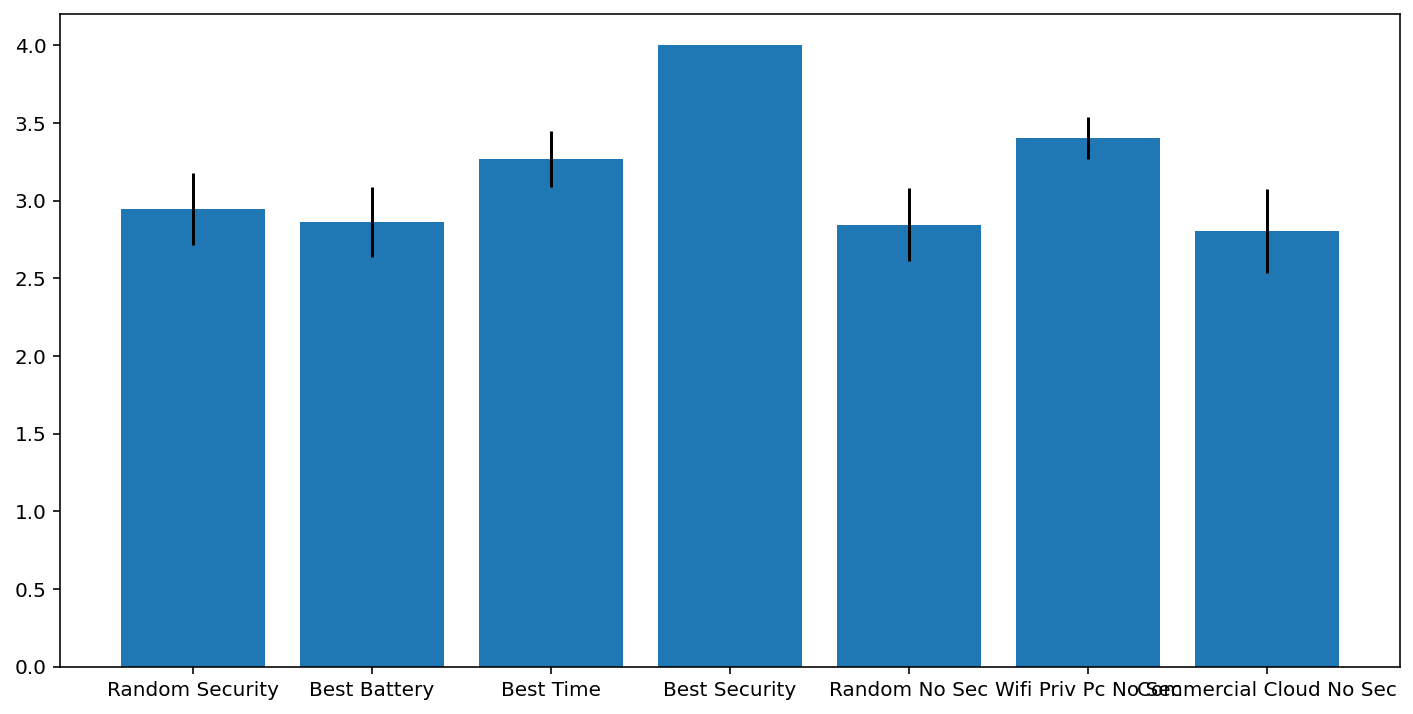

('Random Security', 2.946, 0.2299130270341374)
('Best Battery', 2.8634, 0.22506985582258682)
('Best Time', 3.2666000000000004, 0.1792663939504557)
('Best Security', 4.0, 0.0)
('Random No Sec', 2.8464, 0.23609963998278352)
('Wifi Priv Pc No Sec', 3.4015999999999997, 0.1339755201520039)
('Commercial Cloud No Sec', 2.8072000000000004, 0.2706070213427582)


In [8]:
# bezp
x = [s[0] for s in strategies]
Y_mean, Y_std = list(zip(*[s[1][0] for s in strategies]))
plt.bar(x, Y_mean, yerr=Y_std)
plt.show()
print(*list(zip(x, Y_mean, Y_std)), sep='\n')

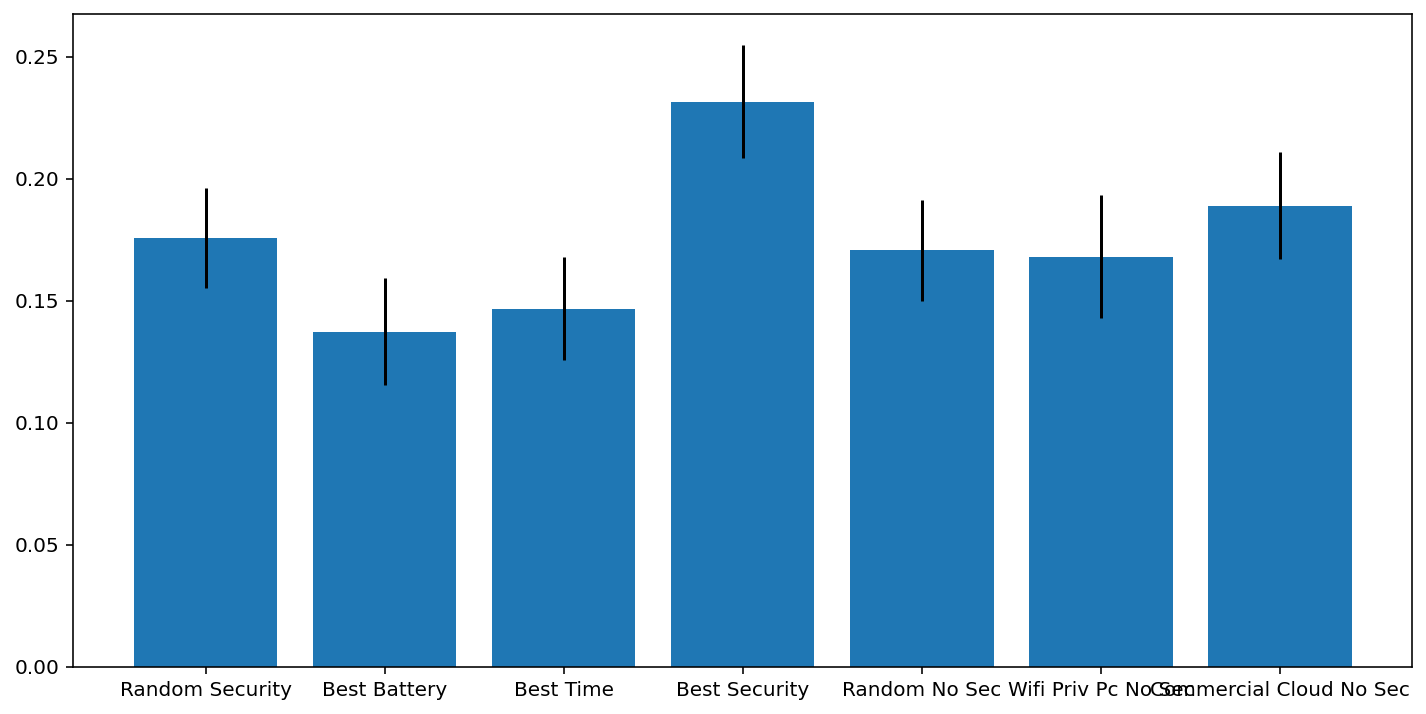

('Random Security', 0.17558939940893173, 0.020452204656286572)
('Best Battery', 0.1373061471820679, 0.021991482810709107)
('Best Time', 0.14671289277612304, 0.021149348278198615)
('Best Security', 0.2316509955103918, 0.02306947985708234)
('Random No Sec', 0.17072478789492307, 0.020750025510562643)
('Wifi Priv Pc No Sec', 0.1680755778374422, 0.025311174118276363)
('Commercial Cloud No Sec', 0.18900508144634795, 0.022034443789106472)


In [9]:
# battery
x = [s[0] for s in strategies]
Y_mean, Y_std = list(zip(*[s[1][1] for s in strategies]))
plt.bar(x, Y_mean, yerr=Y_std)
plt.show()
print(*list(zip(x, Y_mean, Y_std)), sep='\n')

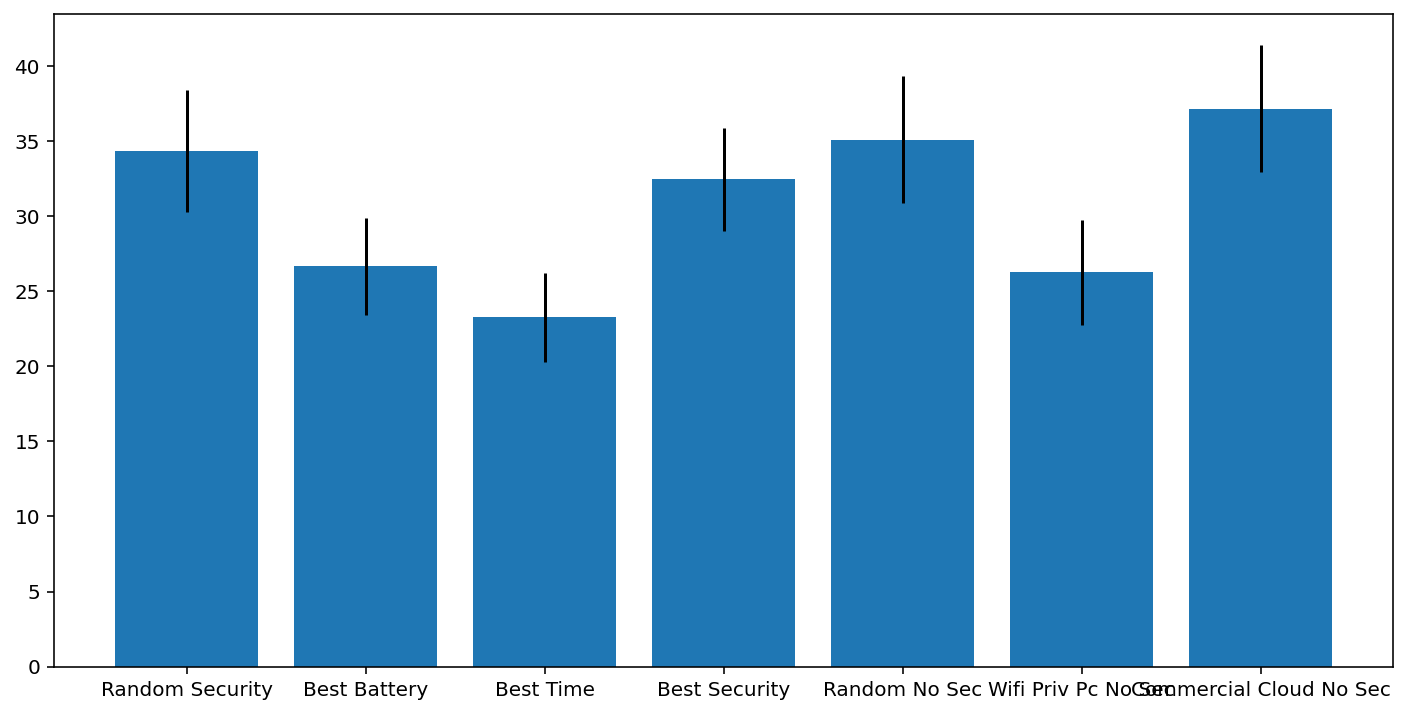

('Random Security', 34.315711260747435, 4.067189492730708)
('Best Battery', 26.660155286368752, 3.2288780543787956)
('Best Time', 23.246366680787563, 2.967881099383131)
('Best Security', 32.445470380781444, 3.4436668370656394)
('Random No Sec', 35.097801639968615, 4.202022387428955)
('Wifi Priv Pc No Sec', 26.250952893740795, 3.4737836920742295)
('Commercial Cloud No Sec', 37.14141418182028, 4.226333138575807)


In [10]:
# time
x = [s[0] for s in strategies]
Y_mean, Y_std = list(zip(*[s[1][2] for s in strategies]))
plt.bar(x, Y_mean, yerr=Y_std)
plt.show()
print(*list(zip(x, Y_mean, Y_std)), sep='\n')